# Problem Set #3
#### MACS 30100, Dr. Evans
#### Mengchen Shi
#### Jan 23th, 2018

## Part 1

In [30]:
# Import packages and load the data
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer')
# This next command is specifically for Jupyter Notebook
%matplotlib notebook

incomes = np.loadtxt('incomes.txt')
print(np.log(incomes).var())
print(np.log(incomes).mean())


0.0448061309494
11.3314403355


### (a)

<IPython.core.display.Javascript object>


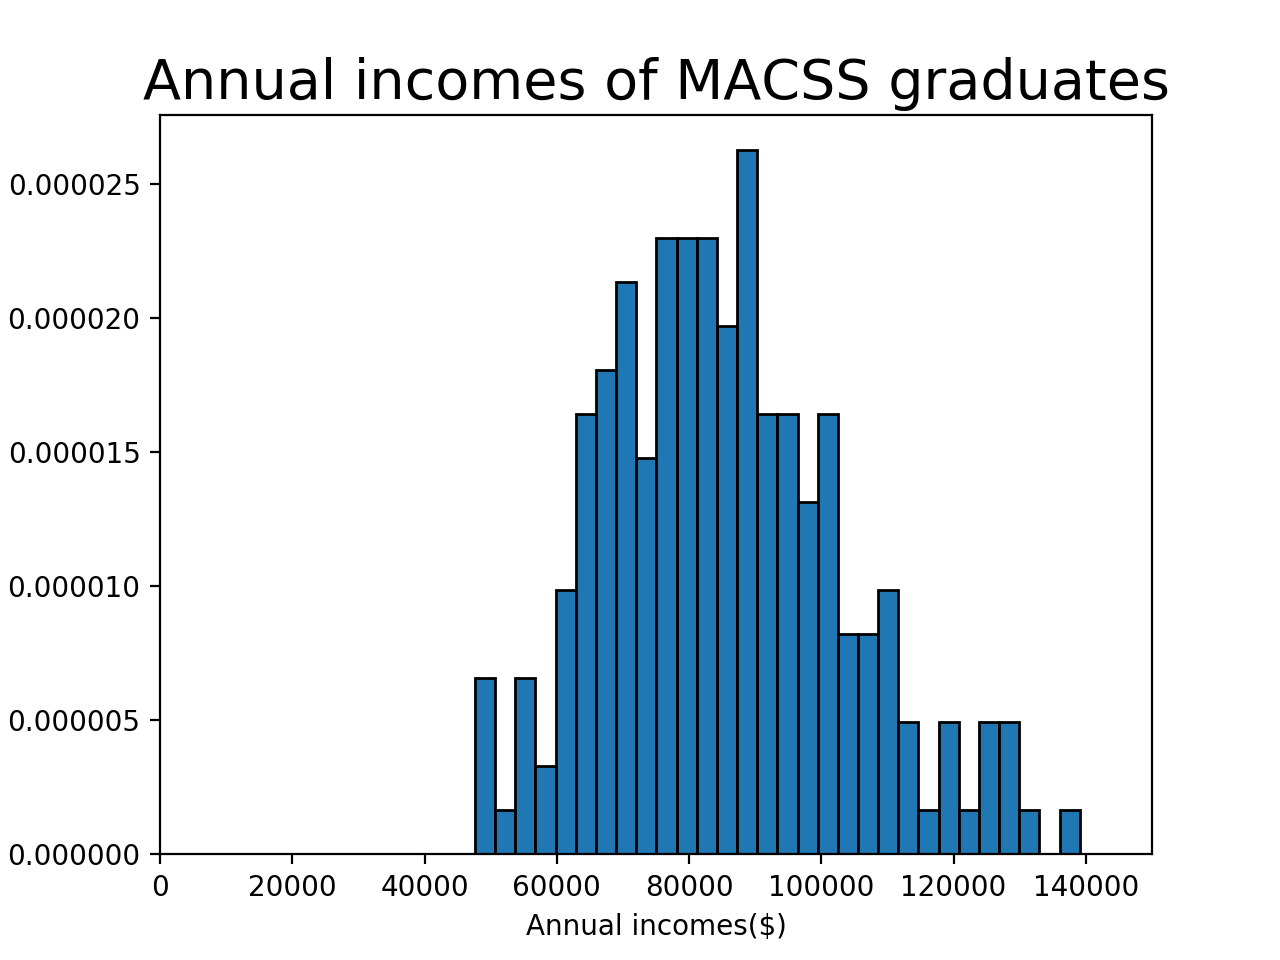

(0, 150000)

In [164]:
count, bins, ignored = plt.hist(incomes, 30,edgecolor='black', normed=True)
plt.title('Annual incomes of MACSS graduates', fontsize=20)
plt.xlabel(r'Annual incomes(\$)')
plt.ylabel('Percent of observations')
plt.xlim([0, 150000])  # This gives the xmin and xmax to be plotted"

### (b)

In [165]:
def log_norm_pdf(xvals, mu, sigma):
    '''
    --------------------------------------------------------------------
    Generate pdf values from the truncated normal pdf with mean mu and
    standard deviation sigma. If the cutoff is finite, then the PDF
    values are inflated upward to reflect the zero probability on values
    above the cutoff. If there is no cutoff given or if it is given as
    infinity, this function does the same thing as
    sp.stats.norm.pdf(x, loc=mu, scale=sigma).
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the normally distributed random
             variable
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
             
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:

    pdf_vals = (N,) vector, normal PDF values for mu and sigma
               corresponding to xvals data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: pdf_vals
    --------------------------------------------------------------------
    '''
            
    pdf_vals = (1/(xvals*sigma*np.sqrt(2*np.pi)))*np.exp(-(((np.log(xvals)-mu)**2)/(2*(sigma**2))))
    
    return pdf_vals



In [166]:
def data_moments(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the two data moments for GMM
    (mean(data), variance(data)).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data = scalar, mean value of test scores data
    var_data  = scalar > 0, variance of test scores data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_data, var_data
    --------------------------------------------------------------------
    '''
    mean_data = xvals.mean()
    var_data = xvals.var()
    sd_data = np.sqrt(var_data)
    
    return mean_data, sd_data

def model_moments(mu, sigma):
    '''
    --------------------------------------------------------------------
    This function computes the two model moments for GMM
    (mean(model data), variance(model data)).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        trunc_norm_pdf()
        xfx()
        x2fx()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_model = scalar, mean value of test scores from model
    m_m_err    = scalar > 0, estimated error in the computation of the
                 integral for the mean of the distribution
    var_model  = scalar > 0, variance of test scores from model
    v_m_err    = scalar > 0, estimated error in the computation of the
                 integral for the variance of the distribution
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_model, var_model
    --------------------------------------------------------------------
    '''
     
    var = sigma**2
    mean_model = np.exp(mu + (var/2))
    sd_model = np.sqrt((np.exp(var)-1)*(np.exp(2*mu + var)))
    
    
    return mean_model, sd_model


def err_vec(xvals, mu, sigma, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments()
        model_moments()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    (mean_data, sd_data) = data_moments(xvals)
    moms_data = np.array([[mean_data], [sd_data]])
    (mean_model, sd_model) = model_moments(mu, sigma)
    moms_model = np.array([[mean_model], [sd_model]])
    
    if simple:
        err_vec = moms_model - moms_data 
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

def criterion(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
             
    args   = length 2 tuple, (xvals, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        norm_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (2, 1) matrix, column vector of two moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    (mu, sigma) = params
    (xvals, W) = args
    err = err_vec(xvals, mu, sigma, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err)
    
    return crit_val

In [167]:
mu_init = 11.0
sigma_init = 0.2

param_init = np.array([mu_init, sigma_init])

W_hat = np.eye(2)
gmm_args = (incomes, W_hat)

results = opt.minimize(criterion, param_init, args=(gmm_args), method='L-BFGS-B', \
                       bounds=((1e-10, None), (1e-10, None)))

mu_GMM1 = results.x[0] 
sig_GMM1 = results.x[1]
print('Estimates of mu and sigma: ', mu_GMM1, sig_GMM1)

mean_data, sd_data = data_moments(incomes)
mean_model, sd_model = model_moments(mu_GMM1, results.x[1])

err1 = err_vec(incomes, mu_GMM1, sig_GMM1, False)


print('Data Mean  =', mean_data, ', Data sd =', sd_data)
print('Model Mean =', mean_model, ', Model sd =', sd_model)
print('Error vector=', err1)
print('Crit. Function Value= ',results.fun)
results

Estimates of mu and sigma:  11.3318809891 0.20869667843
Data Mean  = 85276.8236063 , Data sd = 17992.542128
Model Mean = 85276.8362953 , Model sd = 17992.5462869
Error vector= [[  1.48797923e-07]
 [  2.31140463e-07]]
Crit. Function Value=  [[  7.55667355e-14]]


      fun: array([[  7.55667355e-14]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  7.79877002e-07,   2.68334934e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 39
      nit: 10
   status: 0
  success: True
        x: array([ 11.33188099,   0.20869668])

#### Data moments model moments are very close.

<IPython.core.display.Javascript object>


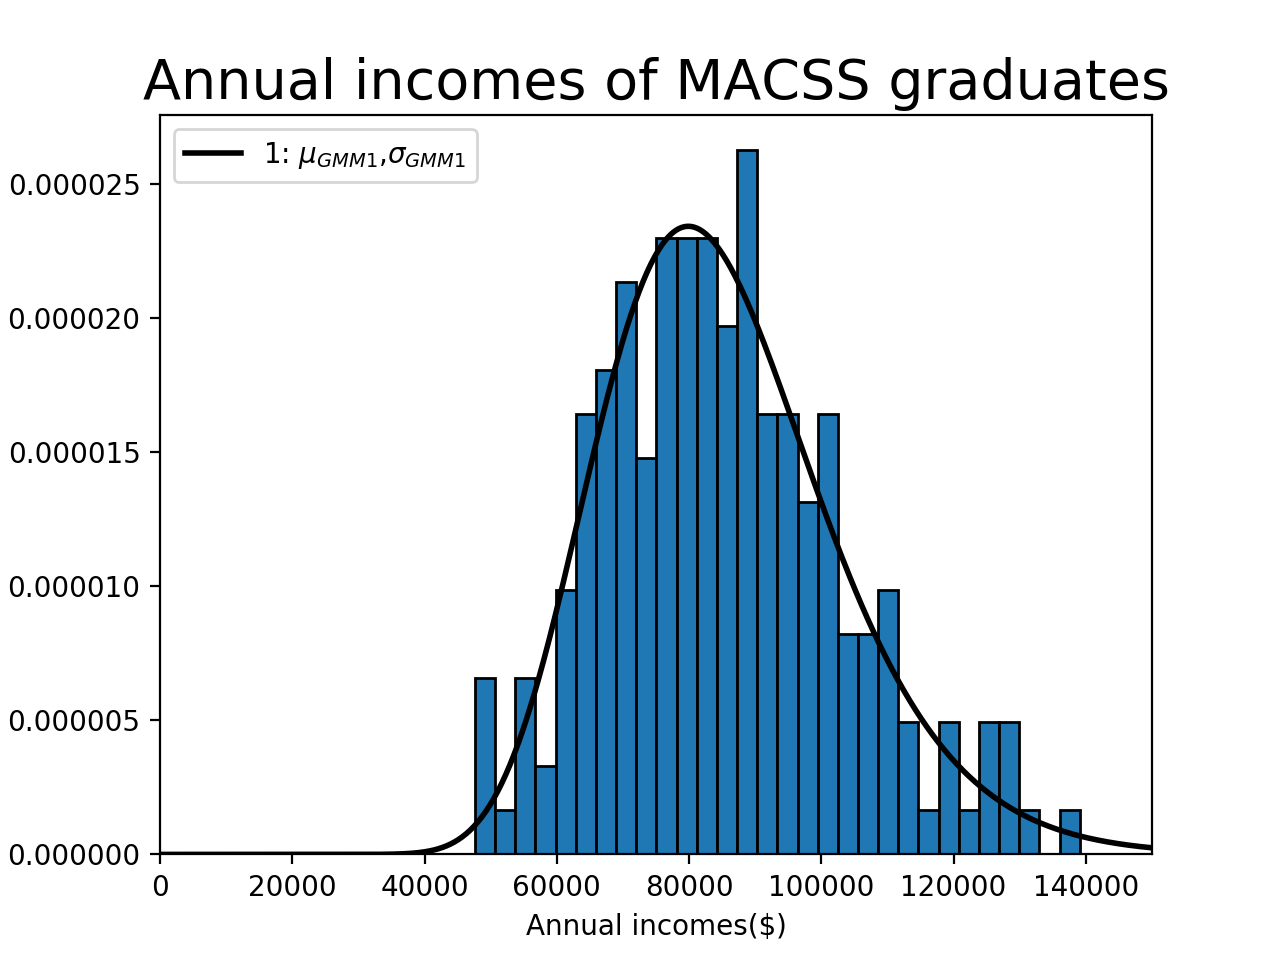

In [168]:
#Plot your estimated lognormal PDF against the histogram from part (a).
# Plot the histogram of the data
count, bins, ignored = plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title('Annual incomes of MACSS graduates', fontsize=20)
plt.xlabel(r'Annual incomes(\$)')
plt.ylabel('Percent of observations')
plt.xlim([0, 150000])  # This gives the xmin and xmax to be plotted"

# Plot the estimated GMM PDF
xvals = np.linspace(1e-10, 150000, 500)
plt.plot(xvals, log_norm_pdf(xvals, mu_GMM1, sig_GMM1),
         linewidth=2, color='k', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')


### (c) 

In [169]:
VCV2 = np.dot(err1, err1.T) / incomes.shape[0]
print(VCV2)
W_hat2 = lin.pinv(VCV2) # Use the pseudo-inverse calculated by SVD because print(W_hat2)
print()
print(W_hat2)

[[  1.10704110e-16   1.71966104e-16]
 [  1.71966104e-16   2.67129568e-16]]

[[  7.75465380e+14   1.20459629e+15]
 [  1.20459629e+15   1.87120182e+15]]


In [170]:
params_init = np.array([mu_GMM1, sig_GMM1])
gmm_args = (incomes, W_hat2)
results2 = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results2.x
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)

mu_GMM2= 11.3318808866  sig_GMM2= 0.208696647916


In [171]:
mean_data, sd_data = data_moments(incomes)
mean_model2, sd_model2 = model_moments(mu_GMM2, sig_GMM2)
err2 = err_vec(incomes, mu_GMM2, sig_GMM2, False)

print('Data Mean  =', mean_data, ', Data sd =', sd_data)
print('Model Mean =', mean_model2, ', Model sd =', sd_model2)
print('Error vector=', err2)
print('Crit. Function Value= ',results2.fun)
results2

Data Mean  = 85276.8236063 , Data sd = 17992.542128
Model Mean = 85276.827018 , Model sd = 17992.541641
Error vector= [[  4.00072797e-08]
 [ -2.70698091e-08]]
Crit. Function Value=  [[ 0.00323527]]


      fun: array([[ 0.00323527]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  4.24698336e+07,   4.87962501e+08])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 330
      nit: 7
   status: 2
  success: False
        x: array([ 11.33188089,   0.20869665])

#### Data moments model moments are very close.

<IPython.core.display.Javascript object>


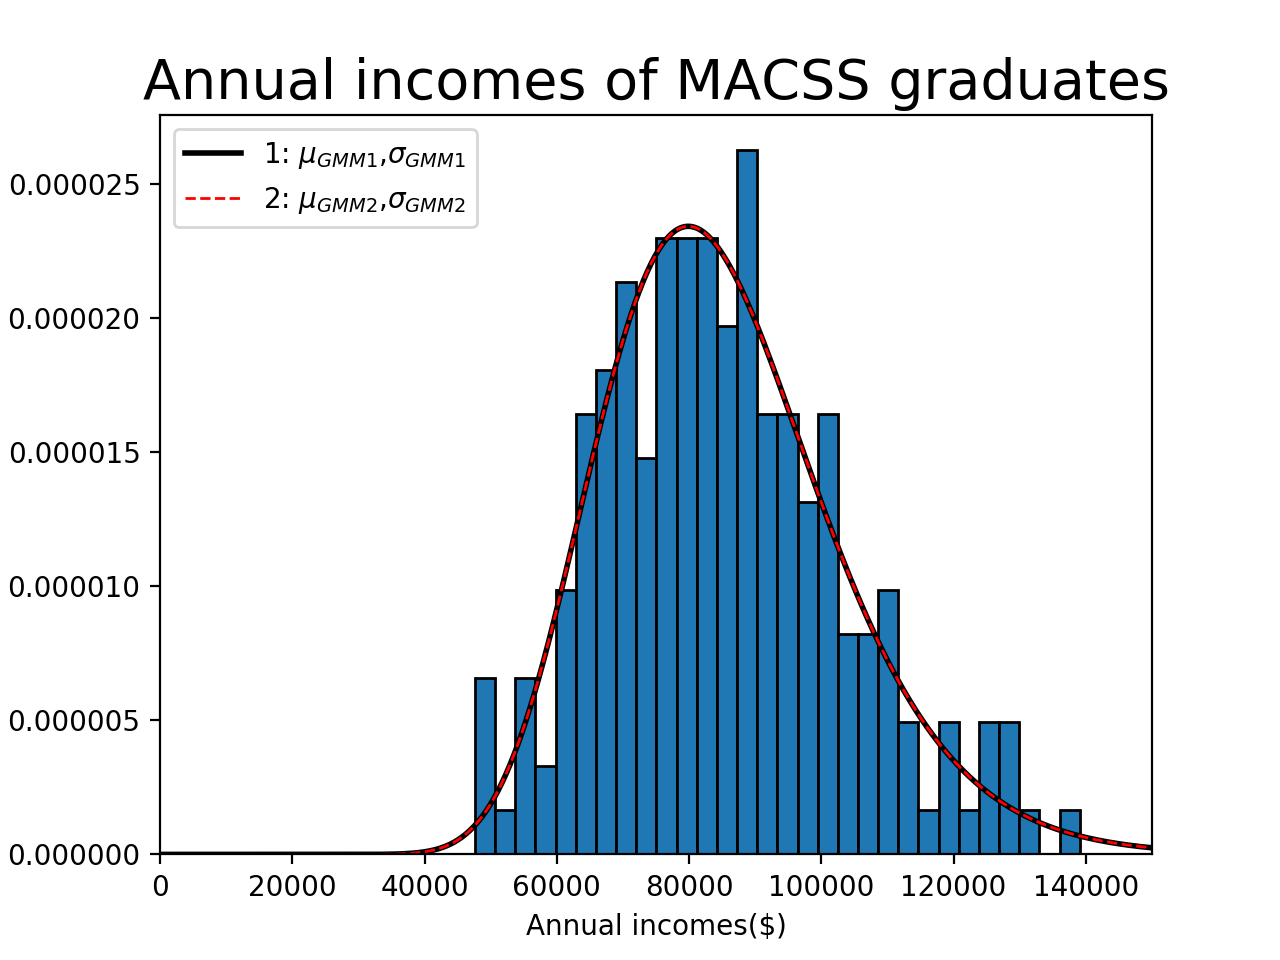

In [172]:
#Plot your estimated lognormal PDF against the histogram from part (a).
# Plot the histogram of the data
count, bins, ignored = plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title('Annual incomes of MACSS graduates', fontsize=20)
plt.xlabel(r'Annual incomes(\$)')
plt.ylabel('Percent of observations')
plt.xlim([0, 150000])  # This gives the xmin and xmax to be plotted"

# Plot the estimated GMM1 PDF
xvals = np.linspace(1e-10, 150000, 500)
plt.plot(xvals, log_norm_pdf(xvals, mu_GMM1, sig_GMM1),
         linewidth=2, color='k', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')

# Plot the estimated GMM2(using 2-step) PDF 
xvals = np.linspace(1e-10, 150000, 500)
plt.plot(xvals, log_norm_pdf(xvals, mu_GMM2, sig_GMM2),
         linewidth=1, color='red', label='2: $\mu_{GMM2}$,$\sigma_{GMM2}$', linestyle='--')
plt.legend(loc='upper left')


### (d)

In [173]:
def data_moments3(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the four data moments for GMM
    (binpct_1, binpct_2, binpct_3, binpct_4).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data

    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None

    OBJECTS CREATED WITHIN FUNCTION:
    bpct_1_dat = scalar in [0, 1], percent of observations
                 0 <= x < 75000
    bpct_2_dat = scalar in [0, 1], percent of observations
                 75000 <= x < 100000
    bpct_3_dat = scalar in [0, 1], percent of observations
                 x >= 100000

    FILES CREATED BY THIS FUNCTION: None

    RETURNS: bpct_1, bpct_2, bpct_3
    --------------------------------------------------------------------
    '''
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] / xvals.shape[0])
    bpct_3_dat = (xvals[(xvals >=100000)].shape[0] / xvals.shape[0])

    return bpct_1_dat, bpct_2_dat, bpct_3_dat


def model_moments3(mu, sigma):
    '''
    --------------------------------------------------------------------
    This function computes the four model moments for GMM
    (binpct_1, binpct_2, binpct_3, binpct_4).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        trunc_norm_pdf()
        xfx()
    
    OBJECTS CREATED WITHIN FUNCTION:
    bpct_1_mod = scalar in [0, 1], percent of model observations in
                 bin 1
    bp_1_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_1_mod
    bpct_2_mod = scalar in [0, 1], percent of model observations in
                 bin 2
    bp_2_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_2_mod
    bpct_3_mod = scalar in [0, 1], percent of model observations in
                 bin 3
    bp_3_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_3_mod
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: bpct_1_mod, bpct_2_mod, bpct_3_mod
    --------------------------------------------------------------------
    '''
    xfx = lambda x: log_norm_pdf(x, mu, sigma)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 1e-10, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    bpct_3_mod = 1- intgr.quad(xfx, 1e-10, 100000)[0]
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod


def err_vec3(xvals, mu, sigma, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments4()
        model_moments4()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
                          
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = 100 * ((moms_model - moms_data) / moms_data)
    
    return err_vec


def criterion3(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 3 tuple, (xvals, cutoff, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        err_vec4()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (4, 1) matrix, column vector of four moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, W = args
    err = err_vec3(xvals, mu, sigma, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [174]:
mu_init3 = 11.0
sig_init3 = 0.2
params_init3 = np.array([mu_init3, sig_init3])
W_hat3 = np.eye(3)
# W_hat[1, 1] = 2.0
# W_hat[2, 2] = 2.0
gmm_args3 = (incomes, W_hat3)
results_3 = opt.minimize(criterion3, params_init3, args=(gmm_args3), method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1_3, sig_GMM1_3 = results_3.x
print('mu_GMM1_3=', mu_GMM1_3, ' sig_GMM1_3=', sig_GMM1_3)
results_3

mu_GMM1_3= 11.3356813294  sig_GMM1_3= 0.210598458926


      fun: array([[  3.58672930e-12]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00486182,  0.00649366])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 111
      nit: 15
   status: 0
  success: True
        x: array([ 11.33568133,   0.21059846])

In [175]:
p1_data, p2_data, p3_data = data_moments3(incomes)
p1_model3, p2_model3, p3_model3 = model_moments3(mu_GMM1_3, sig_GMM1_3)
err3 = err_vec3(incomes, mu_GMM1_3, sig_GMM1_3, False)

print('Data: under 75000  =', p1_data, ', Data from 75000 to 100000 = ', p2_data, 'Data above 100000 =', p3_data)
print('Model under 75000 =', p1_model3, ', Model from 75000 to 100000 =', p2_model3, 'Model above 100000 =', p3_model3)
print('Error vector=', err3)
print('Crit. Function Value= ',results_3.fun)

Data: under 75000  = 0.3 , Data from 75000 to 100000 =  0.5 Data above 100000 = 0.2
Model under 75000 = 0.30000000493119117 , Model from 75000 to 100000 = 0.49999999614886537 Model above 100000 = 0.19999999891994413
Error vector= [[  1.64373039e-06]
 [ -7.70226927e-07]
 [ -5.40027939e-07]]
Crit. Function Value=  [[  3.58672930e-12]]


#### Data moments and model moments are close.

<IPython.core.display.Javascript object>


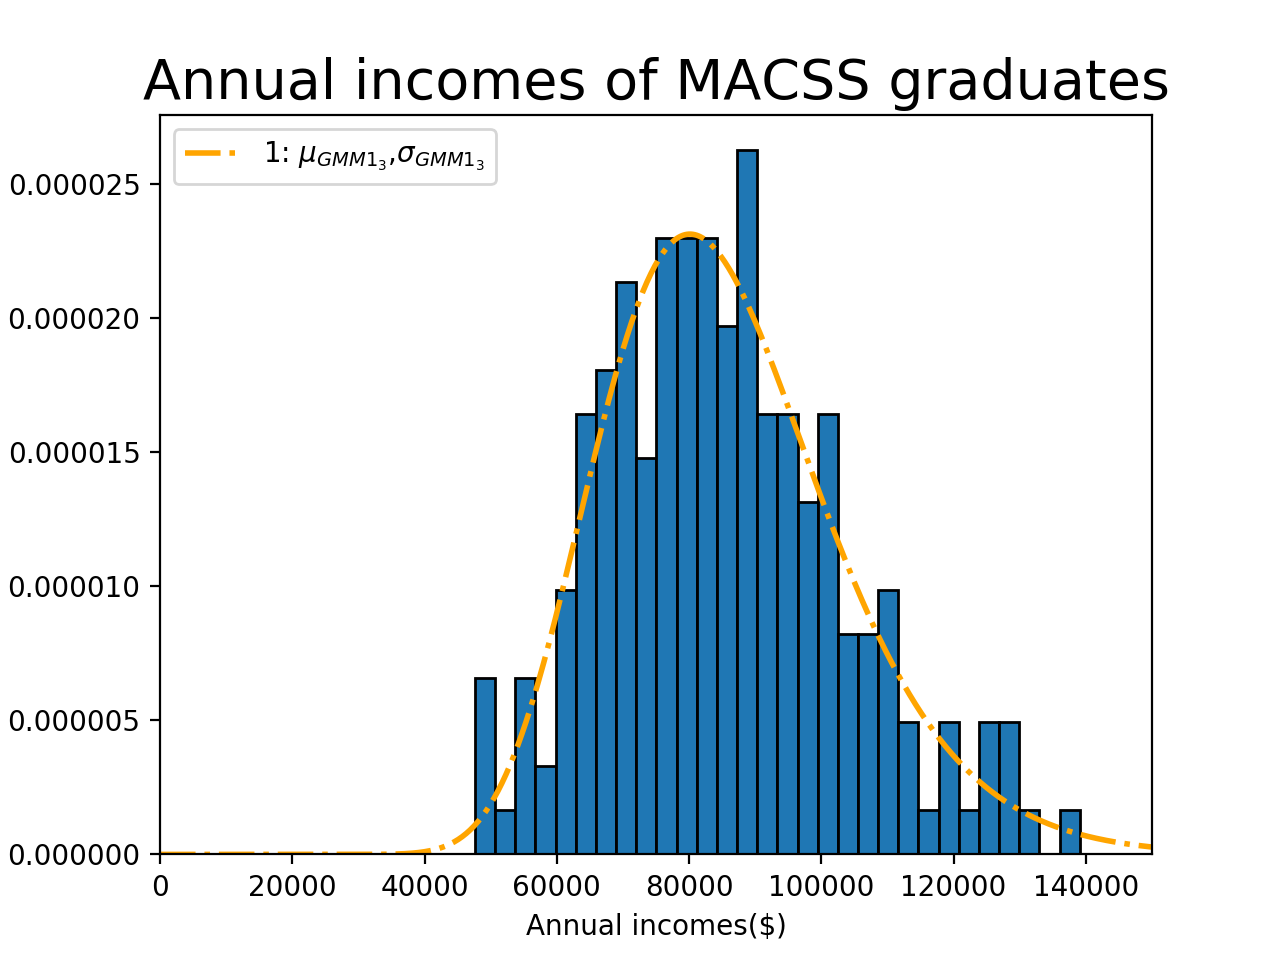

In [181]:
#Plot your estimated lognormal PDF against the histogram from part (a).
# Plot the histogram of the data
count, bins, ignored = plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title('Annual incomes of MACSS graduates', fontsize=20)
plt.xlabel(r'Annual incomes(\$)')
plt.ylabel('Percent of observations')
plt.xlim([0, 150000])  # This gives the xmin and xmax to be plotted"

# Plot the estimated GMM3 PDF
xvals = np.linspace(1e-10, 150000, 500)
plt.plot(xvals, log_norm_pdf(xvals, mu_GMM1_3, sig_GMM1_3),
         linewidth=2, color='orange', label='1: $\mu_{GMM1_3}$,$\sigma_{GMM1_3}$', ls='-.')
plt.legend(loc='upper left')

### (e)

In [182]:
VCV3 = np.dot(err3, err3.T) / incomes.shape[0]
print(VCV3)
W_hat3 = lin.pinv(VCV3) # Use the pseudo-inverse calculated by SVD because print(W_hat2)
print()
print(W_hat3)

[[  1.35092480e-14  -6.33022704e-15  -4.43830168e-15]
 [ -6.33022704e-15   2.96624759e-15   2.07972030e-15]
 [ -4.43830168e-15   2.07972030e-15   1.45815087e-15]]

[[  4.20043207e+13  -1.96825824e+13  -1.38000166e+13]
 [ -1.96825824e+13   9.22295713e+12   6.46647677e+12]
 [ -1.38000166e+13   6.46647677e+12   4.53383023e+12]]


In [186]:
params_init3 = np.array([mu_GMM1_3, sig_GMM1_3])
gmm_args3 = (incomes, W_hat3)
results4 = opt.minimize(criterion3, params_init3, args=(gmm_args3),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM4, sig_GMM4 = results4.x
print('mu_GMM4=', mu_GMM4, ' sig_GMM4=', sig_GMM4)

mu_GMM4= 11.3356813294  sig_GMM4= 0.210598458926


In [188]:
p1_data4, p2_data4, p3_data4 = data_moments3(incomes)
p1_model4, p2_model4, p3_model4 = model_moments3(mu_GMM4, sig_GMM4)
err4 = err_vec(incomes, mu_GMM4, sig_GMM4, False)

print('Data: under 75000  =', p1_data4, ', Data from 75000 to 100000 = ', p2_data4, 'Data above 100000 =', p3_data4)
print('Model under 75000 =', p1_model4, ', Model from 75000 to 100000 =', p2_model4, 'Model above 100000 =', p3_model4)
print('Error vector=', err4)
print('Crit. Function Value= ',results4.fun)
results4

Data: under 75000  = 0.3 , Data from 75000 to 100000 =  0.5 Data above 100000 = 0.2
Model under 75000 = 0.30000000493119117 , Model from 75000 to 100000 = 0.49999999614886537 Model above 100000 = 0.19999999891994413
Error vector= [[ 0.00420802]
 [ 0.01356262]]
Crit. Function Value=  [[ 200.]]


      fun: array([[ 200.]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.21610509e+11,   8.88250318e+10])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 63
      nit: 0
   status: 2
  success: False
        x: array([ 11.33568133,   0.21059846])

#### Data moments and model moments are very close.

<IPython.core.display.Javascript object>


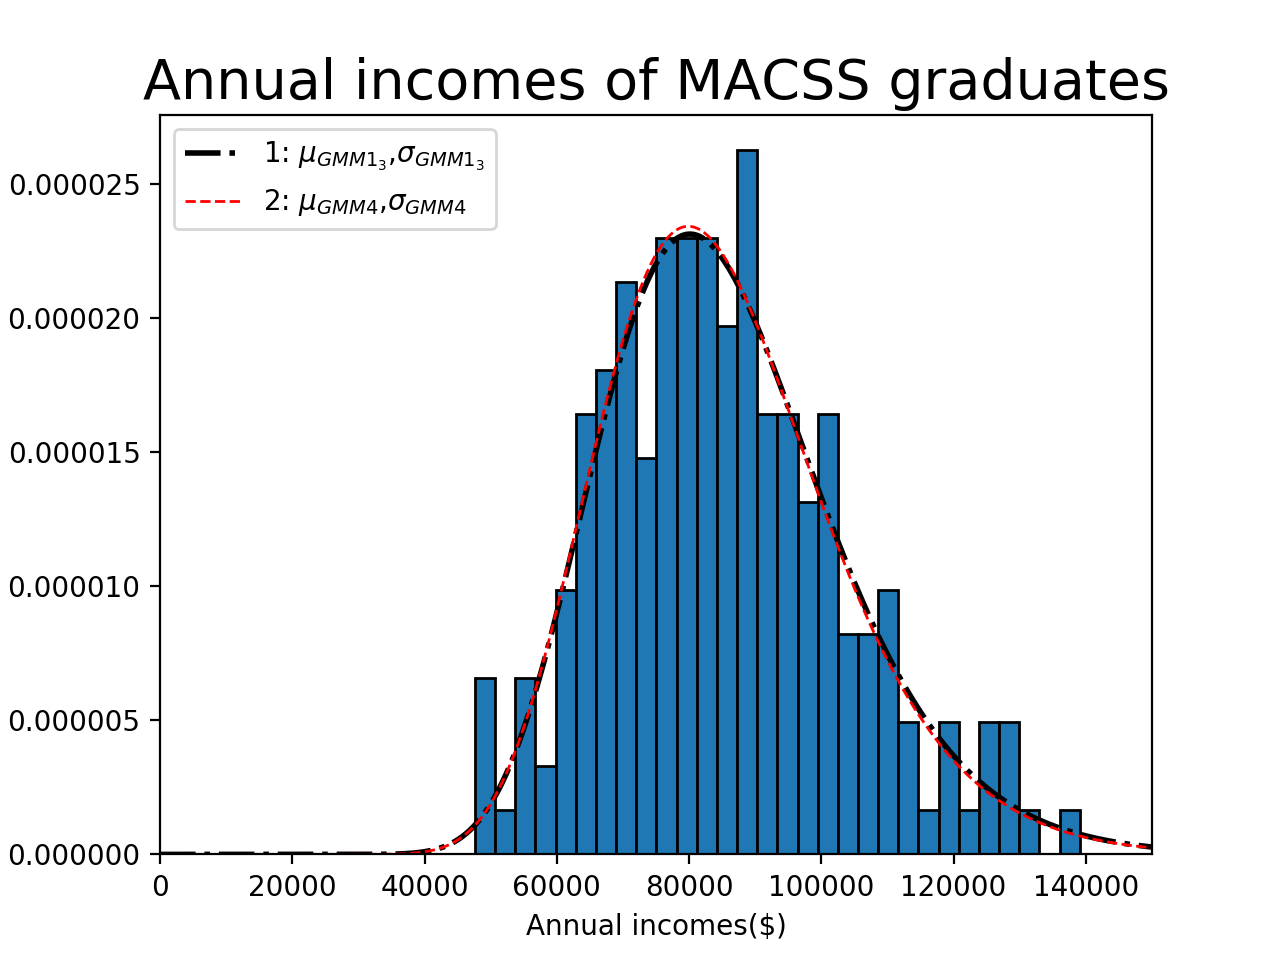

In [189]:
#Plot your estimated lognormal PDF against the histogram from part (a).
# Plot the histogram of the data
count, bins, ignored = plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title('Annual incomes of MACSS graduates', fontsize=20)
plt.xlabel(r'Annual incomes(\$)')
plt.ylabel('Percent of observations')
plt.xlim([0, 150000])  # This gives the xmin and xmax to be plotted"

# Plot the estimated GMM3 PDF
xvals = np.linspace(1e-10, 150000, 500)
plt.plot(xvals, log_norm_pdf(xvals, mu_GMM1_3, sig_GMM1_3),
         linewidth=2, color='k', label='1: $\mu_{GMM1_3}$,$\sigma_{GMM1_3}$', ls='-.')
plt.legend(loc='upper left')

# Plot the estimated GMM2(using 2-step) PDF 
xvals = np.linspace(1e-10, 150000, 500)
plt.plot(xvals, log_norm_pdf(xvals, mu_GMM2, sig_GMM2),
         linewidth=1, color='red', label='2: $\mu_{GMM4}$,$\sigma_{GMM4}$', linestyle='--')
plt.legend(loc='upper left')

### (f)

### Which of the four estimations from parts (b), (c), (d), and (e) fits the data best? Justify your answer.

I think estimation from (b) is the best for following reasons. First, the estimation results are very close. I think choosing mean and standard deviation as moment functions is better, because these two parameters are more commonly used in statistics. In addition, because the value of criteron function of (b) is much smaller than that of (c), we would better choose (b) as the best estimation among others.


## Part 2

### (a)

In [3]:
import pandas as pd
import numpy as np
df = pd.read_csv('sick.txt')
df.head()

,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90


In [49]:
def data_mom(df):
    
    #return np.array(df['sick'])
    return df.iloc[:,0]

def model_mom(df, betas):

    N = df.shape[0] 
    X = np.concatenate((np.ones((200,1)), np.array(df.iloc[:,1:])), axis=1)
    y = X @ betas
    
    return y


def err_fun(df, betas):
    
    y_data = data_mom(df)
    y_model = model_mom(df, betas)
    
    err_fun = y_model - y_data 
    
    return err_fun

def crit(betas, *args):
    (df, W) = args
    err = err_fun(df, betas)
    crit_val = np.dot(np.dot(err.T, W), err)
        
    return crit_val

In [51]:
betas_init = np.array([1,1,1,1])

W_hat = np.eye(200)
gmm_args5 = (df, W_hat)

results5 = opt.minimize(crit, betas_init, args=(gmm_args5), method='L-BFGS-B', bounds=((None, None), (None, None),(None, None), (None, None)))
results5

      fun: 0.0018212898261194513
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([  9.27758955e-05,   3.82943252e-03,   1.30841757e-04,
         4.91734084e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 110
      nit: 14
   status: 0
  success: True
        x: array([ 0.25164422,  0.0129334 ,  0.40050162, -0.00999164])

In [53]:
b0,b1,b2,b3 = results5.x
print('Estimates of b0,b1,b2,b3: ', b0,b1,b2,b3)
print('Crit. Function Value = ',results5.fun)


Estimates of b0,b1,b2,b3:  0.251644217148 0.0129333956424 0.400501622565 -0.00999164445209
Crit. Function Value=  0.00182128982612
